In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
!pip install shap 
import shap


     |████████████████████████████████| 358kB 28.7MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491620 sha256=d2e8eb17f6429732a440c124466c8c80ad4cde62595d4e8fc9bad1473b3e31db
  Stored in directory: /root/.cache/pip/wheels/15/27/f5/a8ab9da52fd159aae6477b5ede6eaaec69fd130fa0fa59f283
Successfully built shap


In [5]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt
import seaborn as sns 

from time import sleep
from datetime import datetime

### 
from sklearn.cluster import KMeans
from collections import defaultdict
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.preprocessing import StandardScaler
###

from pathlib import Path

proj_path = 'drive/MyDrive/6.871 Project Team Folder/'
personal_path = proj_path + 'Eileen Data/'

RNA_RANK = 200
METHYL_RANK = 100

cleaned_data_path = personal_path + 'burden_top{}rna{}methyl_microenv.csv'.format(RNA_RANK, METHYL_RANK)

#Model Training 

- logistic regression
- random forest 
- XGboost 

## Feature Selection

In [6]:
data_df = pd.read_csv(cleaned_data_path)
data_df.drop(columns='Unnamed: 0', inplace=True)
data_df['mutation_count'] = data_df['mutation_count'].fillna(0)
data_df.tail()

,PATIENT_ID,SEX,AGE,PRIMARY_SITE_PATIENT,RACE,SMOKING_PACK_YEARS,CLIN_N_STAGE,CLIN_T_STAGE,CLIN_M_STAGE,CLINICAL_STAGE,OS_MONTHS,BINARY_SURVIVAL,HPV_STATUS,rna_cluster,ACTA1_rna,ACTC1_rna,ACTN2_rna,ADH1C_rna,ADH7_rna,AMTN_rna,ANKRD1_rna,APOBEC2_rna,AQP5_rna,ARPP21_rna,ASB5_rna,ATP12A_rna,ATP1A2_rna,AZGP1_rna,C10orf71_rna,C18orf26_rna,C1orf110_rna,C20orf114_rna,C4orf7_rna,CACNA1S_rna,CACNG1_rna,CALB1_rna,CASP14_rna,CASQ1_rna,CASQ2_rna,CAV3_rna,...,CXCL12_methyl,ZNF844_methyl,ZNF420_methyl,purity,ploidy,mutation_count_protected,pyclone_protected_hg38_vcf_nb_clones,pyclone_protected_hg38_vcf_clonal_prop,pyclone_protected_hg38_vcf_smallest_vaf,pyclone_protected_hg38_vcf_shannon_index,pyclone_protected_hg38_vcf_most_populated_clone_vaf,B cells,Blood vessels,CD8 T cells,Cytotoxic cells,DC,Eosinophils,Lymph vessels,Macrophages,Mast cells,NK CD56bright cells,NK CD56dim cells,NK cells,Neutrophils,Normal mucosa,SW480 cancer cells,T cells,T helper cells,TFH,TReg,Tcm,Tem,Tgd,Th1 cells,Th17 cells,Th2 cells,aDC,iDC,pDC,mutation_count
433,TCGA-UF-A7JT,Female,72,Floor of mouth,WHITE,[Not Available],N0,T4a,M0,Stage IVA,32.62,1,0,1,1.130927,2.604622,0.272191,-2.273994,3.086081,2.758754,0.005410,-1.739704,-0.887941,-3.698764,-1.930373,4.622682,-2.150135,3.419203,-5.545719,-4.095972,-4.645924,-2.273994,1.824988,-2.914661,-2.725928,9.295308,-0.048879,-2.914661,-0.355981,-3.698764,...,0.441410,0.639727,0.517323,0.29,4.136505,513,1.0,100.000000,0.999586,0.000000,0.999586,7.125704,9.589832,10.434405,9.006048,7.588975,7.578036,10.109839,9.980318,4.690458,8.609375,6.833526,8.854102,7.864974,10.314625,9.942515,9.067970,10.714304,8.229274,8.948880,9.100934,9.261703,5.484112,8.936638,4.750517,8.746461,10.009358,8.291730,8.899365,16.0
434,TCGA-UF-A7JV,Female,62,Hypopharynx,WHITE,[Not Available],N2c,T4a,M0,Stage IVA,2.96,1,0,3,-2.464442,-3.307302,-2.909564,-4.240107,0.309675,1.379796,-1.089882,-4.760865,-3.556645,-5.583799,-4.760865,-3.094770,-4.240107,-1.420445,-4.760865,-3.858276,-4.760865,-5.583799,-0.666252,-4.760865,-5.583799,-4.760865,4.703764,-3.858276,-5.583799,-5.583799,...,0.099122,0.551336,0.016916,0.41,2.139104,228,2.0,96.491228,0.304371,0.152005,0.999132,5.989152,9.057637,10.399130,7.736094,8.005082,7.700693,8.553423,10.210945,5.498631,8.527009,5.975930,8.773754,8.170508,10.742077,9.961033,7.710013,10.696636,7.941939,9.064276,9.522097,9.440060,5.416388,8.818538,4.558979,8.695090,8.464090,8.883187,8.939823,5.0
435,TCGA-UP-A6WW,Male,58,Oral Tongue,LATINO,[Not Available],N2c,T2,MX,Stage IVA,17.02,0,1,3,-2.882103,-3.809610,-3.272569,1.851732,5.737869,6.332302,-4.674714,-3.809610,-0.771182,-4.674714,-3.516282,6.389600,-1.754084,-2.322138,-4.178327,-5.437870,-3.809610,-5.437870,7.808259,-4.674714,-4.674714,0.406756,-2.106968,-2.882103,-4.178327,-5.437870,...,0.470670,0.761007,0.015396,0.80,1.800427,147,2.0,80.000000,0.279609,0.500402,0.999378,7.103642,8.685738,9.963105,7.566065,7.605508,7.681422,7.509450,9.066972,6.423828,8.638822,6.146505,8.810458,6.840514,10.760509,10.114533,7.820852,10.670973,8.112180,9.597000,9.076378,9.371545,4.310601,7.583214,5.902602,8.782355,8.121669,9.057447,9.053962,0.0
436,TCGA-WA-A7GZ,Male,58,Floor of mouth,WHITE,20,N0,T2,M0,Stage II,20.53,1,0,2,13.645164,9.025628,10.806070,0.879858,8.053075,-2.813901,3.605937,7.155585,-3.426727,6.105878,5.763022,1.324592,9.822627,0.377187,5.911374,1.833005,-3.087992,-5.705009,-5.705009,7.615982,5.437294,-3.426727,-3.870136,8.780611,7.032447,5.644534,...,0.023587,0.710104,0.015928,0.43,3.637170,604,1.0,100.000000,0.980668,0.000000,0.980668,5.884335,8.425095,9.738513,6.480844,7.158924,7.828342,8.611239,8.509763,6.333599,8.834502,5.547766,8.515728,6.722459,10.685757,10.732020,6.250940,10.327467,7.732918,7.161875,9.470309,9.560411,4.027635,7.125812,4.179520,8.981270,8.649308,8.487441,6.951138,11.0
437,TCGA-WA-A7H4,Male,69,Oral Tongue,WHITE,25,N0,T2,M0,Stage II,14.55,0,0,2,9.228520,8.801350,8.107051,-0.748827,1.583017,5.837908,5.592343,4.121111,6.544955,2.992852,4.849789,-1.080053,5.043802,8.

In [21]:
categorical_features = ['SEX', 'PRIMARY_SITE_PATIENT', 'RACE', 'CLIN_N_STAGE', 'CLIN_T_STAGE', 'CLIN_M_STAGE', 'CLINICAL_STAGE', 'rna_cluster' ]
omit_features = [
                 'RACE', 
                 'CLIN_N_STAGE', 
                 'CLIN_T_STAGE', 
                 'CLIN_M_STAGE', 
                 'CLINICAL_STAGE',
                 'PRIMARY_SITE_PATIENT',
                 'rna_cluster',
                 #'mutation_count', 
                 #'mutation_count_protected'
                 'SMOKING_PACK_YEARS', 
                 ]

present_categorical_feat = list(set(categorical_features) - set(omit_features))

dropped_data = data_df.drop(columns = omit_features)
num_columns = dropped_data.columns.difference(present_categorical_feat)

cat_feat = pd.get_dummies(dropped_data[present_categorical_feat], columns=present_categorical_feat)
num_feat = dropped_data[num_columns].replace('[Not Available]', np.nan)
final_df = pd.concat([cat_feat, num_feat], axis=1).drop(columns='SEX_Male')

#CATEGORICAL FEATURES ONE-HOTTED 
one_hot_cat_feat = list(set(cat_feat.columns) - set(['SEX_Male']))

final_df.tail()

,SEX_Female,ACTA1_rna,ACTC1_rna,ACTN2_rna,ADAMTS16_methyl,ADH1C_rna,ADH7_rna,AEBP1_methyl,AGE,AGPAT4_methyl,AMTN_rna,ANKRD1_rna,APBB1_methyl,APOBEC2_rna,AQP5_rna,ARPP21_rna,ASB2_methyl,ASB5_rna,ASPRV1_methyl,ATP12A_rna,ATP1A2_rna,AZGP1_rna,B cells,B4GALNT1_methyl,B4GALNT2_methyl,BINARY_SURVIVAL,Blood vessels,C10orf71_rna,C13orf18_methyl,C13orf33_methyl,C18orf26_rna,C1orf110_rna,C20orf114_rna,C4orf7_rna,CACNA1S_rna,CACNG1_rna,CALB1_rna,CASP14_rna,CASQ1_rna,CASQ2_rna,...,Th2 cells,UGT1A10_rna,UGT1A6_rna,UGT1A7_rna,UGT1A9_rna,UNC45B_rna,UPK1B_rna,USP9Y_rna,UTY_rna,VAMP5_methyl,WFDC12_rna,WFDC1_methyl,WFDC2_rna,WIF1_rna,WWOX_methyl,XIRP2_rna,XIST_rna,ZBED3_methyl,ZFP28_methyl,ZFY_rna,ZG16B_rna,ZNF167_methyl,ZNF420_methyl,ZNF549_methyl,ZNF625_methyl,ZNF737_methyl,ZNF844_methyl,ZNHIT2_rna,aDC,iDC,mutation_count,mutation_count_protected,pDC,ploidy,purity,pyclone_protected_hg38_vcf_clonal_prop,pyclone_protected_hg38_vcf_most_populated_clone_vaf,pyclone_protected_hg38_vcf_nb_clones,pyclone_protected_hg38_vcf_shannon_index,pyclone_protected_hg38_vcf_smallest_vaf
433,1,1.130927,2.604622,0.272191,0.557044,-2.273994,3.086081,0.591735,72,0.504631,2.758754,0.005410,0.610255,-1.739704,-0.887941,-3.698764,0.757544,-1.930373,0.744787,4.622682,-2.150135,3.419203,7.125704,0.585104,0.949886,1,9.589832,-5.545719,0.449733,0.622852,-4.095972,-4.645924,-2.273994,1.824988,-2.914661,-2.725928,9.295308,-0.048879,-2.914661,-0.355981,...,8.746461,-3.465266,-1.519025,-5.545719,-5.545719,-2.914661,-1.100840,-5.545719,-4.095972,0.538787,5.356320,0.950683,-1.420547,-4.645924,0.963398,0.157000,6.254710,0.742893,0.474068,-5.545719,-2.409494,0.790943,0.517323,0.246023,0.171754,0.484964,0.639727,4.030017,10.009358,8.291730,16.0,513,8.899365,4.136505,0.29,100.000000,0.999586,1.0,0.000000,0.999586
434,1,-2.464442,-3.307302,-2.909564,0.134842,-4.240107,0.309675,0.480374,62,0.379365,1.379796,-1.089882,0.248444,-4.760865,-3.556645,-5.583799,0.491780,-4.760865,0.968841,-3.094770,-4.240107,-1.420445,5.989152,0.438671,0.767864,1,9.057637,-4.760865,0.079804,0.080593,-3.858276,-4.760865,-5.583799,-0.666252,-4.760865,-5.583799,-4.760865,4.703764,-3.858276,-5.583799,...,8.695090,-2.188681,-0.528750,-3.786288,-2.830108,-4.760865,-0.253979,-4.760865,-4.240107,0.602231,-3.858276,0.965599,6.798264,0.517868,0.927480,-3.556645,8.792146,0.590920,0.577512,-3.858276,-0.862579,0.098108,0.016916,0.089910,0.060294,0.071249,0.551336,2.948067,8.464090,8.883187,5.0,228,8.939823,2.139104,0.41,96.491228,0.999132,2.0,0.152005,0.304371
435,0,-2.882103,-3.809610,-3.272569,0.855501,1.851732,5.737869,0.031688,58,0.905073,6.332302,-4.674714,0.065876,-3.809610,-0.771182,-4.674714,0.026114,-3.516282,0.979494,6.389600,-1.754084,-2.322138,7.103642,0.731911,0.099019,0,8.685738,-4.178327,0.791005,0.737221,-5.437870,-3.809610,-5.437870,7.808259,-4.674714,-4.674714,0.406756,-2.106968,-2.882103,-4.178327,...,8.782355,-5.437870,6.914786,-2.506301,3.383689,-3.272569,4.350415,3.684418,4.243013,0.027268,-3.809610,0.954687,7.927987,-5.437870,0.218201,-3.516282,-1.374385,0.857598,0.029369,2.888434,-0.895154,0.884296,0.015396,0.878574,0.694964,0.775951,0.761007,4.176899,8.121669,9.057447,0.0,147,9.053962,1.800427,0.80,80.000000,0.999378,2.0,0.500402,0.279609
436,0,13.645164,9.025628,10.806070,0.024072,0.879858,8.053075,0.702227,58,0.890681,-2.813901,3.605937,0.056027,7.155585,-3.426727,6.105878,0.683815,5.763022,0.472447,1.324592,9.822627,0.377187,5.884335,0.443586,0.943694,1,8.425095,5.911374,0.635241,0.668255,1.833005,-3.087992,-5.705009,-5.705009,7.615982,5.437294,-3.426727,-3.870136,8.780611,7.032447,...,8.981270,3.107162,5.526600,6.397715,2.578380,7.380189,3.812085,5.413335,4.625084,0.649967,0.738064,0.680485,-2.055025,-1.459224,0.279617,9.825252,-2.504944,0.114485,0.089975,3.742172,-3.087992,0.131715,0.015928,0.757524,0.522802,0.042285,0.710104,2.333220,8.649308,8.487441,11.0,604,6.951138,3.637170,0.43,100.000000,0.980668,1.0,0.000000,0.980668
437,0,9.228520,8.801350,8.107051,0.063285,-0.748827,1.583017,0.42

In [13]:
print(one_hot_cat_feat)

['SEX_Female']


## Training

In [27]:
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer


def preprocess_pipeline(impute_missing_val=True):
  categorical_features = one_hot_cat_feat
  categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0)),
        ])

  numeric_features = list(set(X.columns) - set(one_hot_cat_feat))

  if impute_missing_val:
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(missing_values=np.nan, strategy='median')),
        ('scaler', StandardScaler())
        ])
  else: 
    numeric_transformer = Pipeline(steps=[
        ('scaler', StandardScaler())
        ])

  preprocessor = ColumnTransformer(
      transformers=[
          ('num', numeric_transformer, numeric_features),
          ('cat', categorical_transformer, one_hot_cat_feat)
          ])
  return preprocessor 

def cv_pipeline(X, y, clf, scoring='roc_auc' , impute=True):
  preprocessor = preprocess_pipeline(impute_missing_val= impute)
  pipeline = Pipeline([('preproc', preprocessor), ('estimator', clf)])

  cv_results = cross_validate(pipeline, X, y, cv=5, scoring=scoring)
  return np.mean(cv_results['test_score'])

"""
tiny_df = final_df[list(xgb_just_25feat)+['BINARY_SURVIVAL']]
X, y = tiny_df.drop(columns=['BINARY_SURVIVAL']), tiny_df['BINARY_SURVIVAL']
"""
X, y = final_df.drop(columns=['PATIENT_ID','BINARY_SURVIVAL', 'OS_MONTHS']), final_df['BINARY_SURVIVAL']


rfc_clf = RandomForestClassifier(n_estimators=250, max_depth=5, min_samples_leaf=10)
print("rfc roc_score:", cv_pipeline(X, y, rfc_clf))

lr_l1_clf = LogisticRegression(penalty='l1', solver='liblinear', C=.1, class_weight='balanced')
print("lr roc_score:", cv_pipeline(X, y, lr_l1_clf))

XGB_clf = XGBClassifier()
print("xgb roc_score:", cv_pipeline(X, y, XGB_clf, impute=False))

rfc roc_score: 0.6566553544494722
lr roc_score: 0.6439179564179563
xgb roc_score: 0.6809630897866192


In [32]:
from sklearn.model_selection import train_test_split
def fit_pipeline(X, y, clf, scoring='roc_auc', impute=True):
  X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.3, random_state=5)
  preprocessor = preprocess_pipeline(impute_missing_val=impute)
  pipeline = Pipeline([('preproc', preprocessor), ('estimator', clf)])

  pipeline.fit(X_train, y_train)
  
  print(pipeline.score(X_test, y_test))
  return pipeline


X, y = final_df.drop(columns=['PATIENT_ID','BINARY_SURVIVAL', 'OS_MONTHS']), final_df['BINARY_SURVIVAL']
lr_l1_clf = LogisticRegression(penalty='l1', solver='liblinear', C=.1, class_weight='balanced')
print("single lr roc_score:")
lr_pipe = fit_pipeline(X, y, lr_l1_clf)

rfc_clf = RandomForestClassifier(n_estimators=250, max_depth=5)
print("single rfc roc_score:")
rfc_pipe = fit_pipeline(X, y, rfc_clf)

XGB_clf = XGBClassifier()
print("xgb roc_score:")
xgb_pipe = fit_pipeline(X, y, XGB_clf, impute=False)


single lr roc_score:
0.6515151515151515
single rfc roc_score:
0.696969696969697
xgb roc_score:
0.6818181818181818


# Logistic Regression Analysis 

In [ ]:
coeffsdict = {}
coeffs = lr_l1_clf.coef_[0]
print(len(coeffs))
print(len(X.columns))

359
359


In [ ]:
coef_list = [ (val, label) for (val, label) in zip(coeffs, X.columns) if val != 0]
coef_list = sorted(coef_list, key=lambda item: abs(item[0]),  reverse=True)
print("survival determining", coef_list)


survival determining [(0.2285287497695008, 'C13orf33_methyl'), (0.22289576815553308, 'MAGEA3_rna'), (-0.22033587823988432, 'DEFB4A_rna'), (-0.17298273626119018, 'CASQ1_rna'), (0.1478201642690574, 'CDSN_rna'), (-0.12748805679065894, 'IGF2BP1_rna'), (-0.12205389623561531, 'R3HDM1_methyl'), (-0.12167058601549638, 'KLK14_rna'), (0.11672883184642123, 'C10orf71_rna'), (0.11551308313691677, 'CHAD_methyl'), (-0.0976025034570611, 'AMTN_rna'), (-0.09073445803016293, 'ASB5_rna'), (0.07821152819781922, 'SW480 cancer cells'), (-0.06840561135222226, 'MMP13_rna'), (-0.06275706779502675, 'MYEF2_methyl'), (-0.05970527165807386, 'MYOZ2_rna'), (-0.05927446102497871, 'MYRIP_methyl'), (-0.05479100770843528, 'CD1D_methyl'), (-0.054382429786913745, 'CACNG1_rna'), (-0.048861216113173546, 'PPP1R1B_rna'), (-0.04154969364632613, 'SLC34A2_rna'), (0.03601667084696902, 'KLK12_rna'), (0.03353460757652724, 'AGE'), (0.031049342456811114, 'CLIN_T_STAGE_T4b'), (0.028664500074081042, 'TCAP_rna'), (-0.0195070363345439, 'T

In [ ]:
non_0_weight_methyl = [item[1][:-7] for item in coef_list if '_methyl' in item[1]]
weights_methyl =  [item[0] for item in coef_list if '_methyl' in item[1]]
print("methylation", non_0_weight_methyl)
#print("weights", weights_methyl)
non_0_weight_rna = [item[1][:-4] for item in coef_list if '_rna' in item[1]]
weights_rna = [item[0] for item in coef_list if '_rna' in item[1]]
print("rna", non_0_weight_rna)
non_0_other = [item[1] for item in coef_list if not ('_rna' in item[1] or '_methyl' in item[1]) ]
print("other", non_0_other)

methylation ['CHAD', 'MGST1', 'SLCO1A2', 'NRIP2', 'ZNF167', 'OSR1', 'TMEM121', 'CDKL2', 'DNAH14', 'CDK14', 'B4GALNT2', 'HLA-DRB6']
rna ['KLK13', 'MYH7', 'KRTDAP', 'SERPINB11', 'ACTA1', 'MUC21', 'DUSP27', 'MYBPH', 'MYLPF', 'SLURP1', 'LYPD2', 'CASQ2', 'USP9Y', 'MAGEA9B', 'C10orf71', 'ASB5', 'ATP12A', 'KRT1', 'RPTN', 'TNNC2']
other ['CD8 T cells', 'PRIMARY_SITE_PATIENT_Base of tongue', 'NK CD56bright cells', 'PRIMARY_SITE_PATIENT_Floor of mouth']


In [ ]:
methyl_genes = pd.DataFrame(data=non_0_weight_methyl, columns=['methyl_100_100'])
rna_genes = pd.DataFrame(data=non_0_weight_rna, columns=['rna_100_100'])
merge_genes = pd.concat([methyl_genes, rna_genes], axis=1)
merge_genes.head()

,methyl_100_100,rna_100_100
0,SOX2,CHRND
1,SLCO4C1,KRT2
2,MYEF2,MYOT
3,POU3F1,CDKN2A
4,MYRIP,LOC84740


In [ ]:
merge_genes.to_csv('merge_genes', index=False

#XGBoost Analysis 

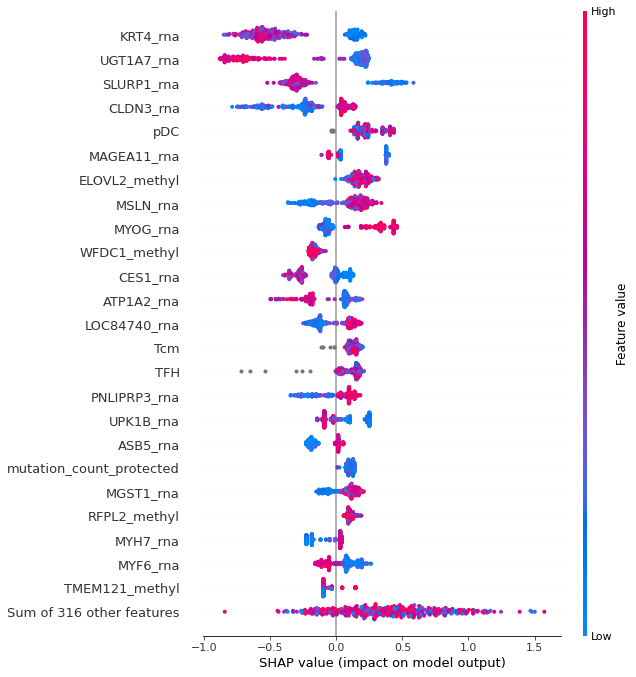

In [35]:
explainer = shap.TreeExplainer(XGB_clf)
shap_values = explainer(X)
shap.plots.beeswarm(shap_values, max_display=25)

In [34]:
def global_shap_importance(model, X):
    """ Return a dataframe containing the features sorted by Shap importance
    Parameters
    ----------
    model : The tree-based model 
    X : pd.Dataframe
         training set/test set/the whole dataset ... (without the label)
    Returns
    -------
    pd.Dataframe
        A dataframe containing the features sorted by Shap importance
    """
    explainer = shap.Explainer(model)
    shap_values = explainer(X)
    cohorts = {"": shap_values}
    cohort_labels = list(cohorts.keys())
    cohort_exps = list(cohorts.values())
    for i in range(len(cohort_exps)):
        if len(cohort_exps[i].shape) == 2:
            cohort_exps[i] = cohort_exps[i].abs.mean(0)
    features = cohort_exps[0].data
    feature_names = cohort_exps[0].feature_names
    values = np.array([cohort_exps[i].values for i in range(len(cohort_exps))])
    feature_importance = pd.DataFrame(
        list(zip(feature_names, sum(values))), columns=['features', 'importance'])
    feature_importance.sort_values(
        by=['importance'], ascending=False, inplace=True)
    return feature_importance

def sort_importance(feature_importance):
  feature_importance['RNA'] = feature_importance['features'].apply(lambda x: x[:-4] if '_rna' in x else np.nan)
  feature_importance['Methyl'] = feature_importance['features'].apply(lambda x: x[:-7] if '_methyl' in x else np.nan)
  feature_importance['Other'] = feature_importance['features'].apply(lambda x: x if not('_methyl' in x or '_rna' in x) else np.nan)
  ranked_importance = feature_importance.reset_index().drop(columns='index')
  return ranked_importance

feature_importance = global_shap_importance(XGB_clf, X)
xgb_import_df = sort_importance(feature_importance)
xgb_import_df.head()

,features,importance,RNA,Methyl,Other
0,HSPB7_rna,0.336357,HSPB7,NaN,NaN
1,GSTM1_rna,0.280453,GSTM1,NaN,NaN
2,ADH1C_rna,0.236217,ADH1C,NaN,NaN
3,ACTN2_rna,0.235620,ACTN2,NaN,NaN
4,TMPRSS11A_rna,0.210944,TMPRSS11A,NaN,NaN


In [27]:
xgb_import_df.to_csv(personal_path+'clustered_xgb_shap_importance.csv')

# RFC analysis 

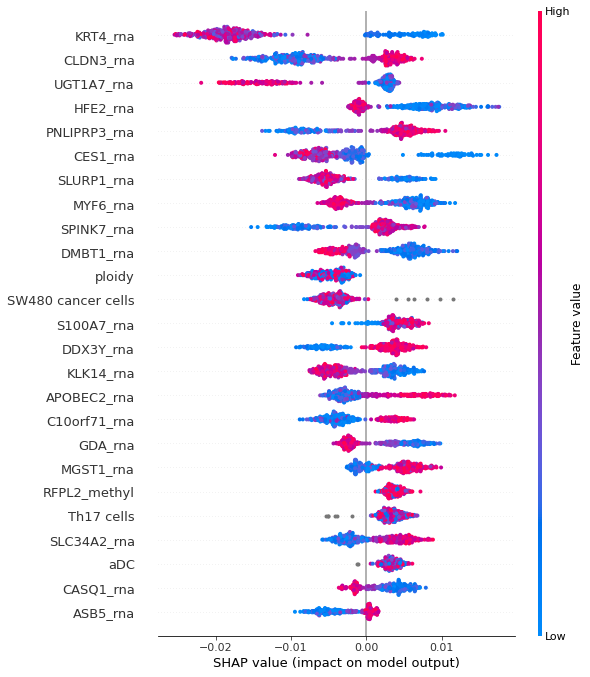

In [34]:
explainer = shap.TreeExplainer(rfc_clf)
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values[1], X, max_display=25)

In [36]:
def global_shap_importance(model, X):
    """ Return a dataframe containing the features sorted by Shap importance
    Parameters
    ----------
    model : The tree-based model 
    X : pd.Dataframe
         training set/test set/the whole dataset ... (without the label)
    Returns
    -------
    pd.Dataframe
        A dataframe containing the features sorted by Shap importance
    """
    explainer = shap.Explainer(model)
    shap_values = explainer(X)
    cohorts = {"": shap_values}
    cohort_labels = list(cohorts.keys())
    cohort_exps = list(cohorts.values())
    for i in range(len(cohort_exps)):
        if len(cohort_exps[i].shape) == 2:
            cohort_exps[i] = cohort_exps[i].abs.mean(0)
    features = cohort_exps[0].data
    feature_names = cohort_exps[0].feature_names
    values = np.array([cohort_exps[i].values for i in range(len(cohort_exps))])
    feature_importance = pd.DataFrame(
        list(zip(feature_names, sum(values)[0,:, 1])), columns=['features', 'importance'])
    feature_importance.sort_values(
        by=['importance'], ascending=False, inplace=True)
    return feature_importance

def sort_importance(feature_importance):
  feature_importance['RNA'] = feature_importance['features'].apply(lambda x: x[:-4] if '_rna' in x else np.nan)
  feature_importance['Methyl'] = feature_importance['features'].apply(lambda x: x[:-7] if '_methyl' in x else np.nan)
  feature_importance['Other'] = feature_importance['features'].apply(lambda x: x if not('_methyl' in x or '_rna' in x) else np.nan)
  ranked_importance = feature_importance.reset_index().drop(columns='index')
  return ranked_importance

feature_importance = global_shap_importance(rfc_clf, X)
rfc_import_df = sort_importance(feature_importance)
rfc_import_df.head()

,features,importance,RNA,Methyl,Other
0,WFDC2_rna,0.015203,WFDC2,NaN,NaN
1,KRTDAP_rna,0.007520,KRTDAP,NaN,NaN
2,UGT1A9_rna,0.006850,UGT1A9,NaN,NaN
3,DEFB4A_rna,0.006707,DEFB4A,NaN,NaN
4,OLFM4_rna,0.006354,OLFM4,NaN,NaN


In [47]:
rfc_import_df.to_csv(personal_path+'rfc_shap_importance.csv')

In [37]:
rfc_top25 = rfc_import_df.RNA.dropna().iloc[:50]
xgb_top25 = xgb_import_df.RNA.dropna().iloc[:50]

print( set(rfc_top25).intersection(set(xgb_top25)))

{'UGT1A9', 'PRSS21', 'GSTM1', 'CSAG1', 'KLK13', 'OLFM4', 'WFDC2', 'PTH2R', 'LCE3D', 'WFDC12', 'KLK12', 'SLURP1', 'SLN', 'MYL1'}


In [43]:
xgb_just_25feat = xgb_import_df.features.iloc[:25]


,HSPB7_rna,GSTM1_rna,ADH1C_rna,ACTN2_rna,TMPRSS11A_rna,TNNC1_rna,WFDC2_rna,ITGB1BP3_rna,UGT1A9_rna,KRT1_rna,SLN_rna,WFDC1_methyl,Cytotoxic cells,SCGB3A1_rna,MYF6_rna,SPINK6_rna,KLK13_rna,CSAG2_rna,ZNF167_methyl,USP9Y_rna,PRSS21_rna,KLK12_rna,SOX2_methyl,WFDC12_rna,NK CD56bright cells,BINARY_SURVIVAL
0,5.397606,3.549709,-3.743013,5.08515,-0.926054,5.882562,6.031195,1.729297,2.346375,3.161488,4.286921,0.860824,8.105936,-1.672207,3.323389,-4.377273,6.765624,1.010032,0.135661,1.317381,5.026388,2.247985,0.629063,-0.601380,9.093984,0
1,2.250317,5.312101,-2.965188,0.15801,2.022687,3.284314,2.957405,-3.363108,-0.127235,-3.150472,1.377006,0.554804,6.747576,-0.309192,-0.876369,-1.991297,3.438076,0.843935,0.515617,4.029667,-1.674629,0.904543,0.586064,-1.747521,7.562580,1
2,-1.963830,-3.854912,-5.486715,-3.43416,1.226104,-4.451513,2.000381,-5.486715,-1.249319,9.020415,-3.434160,0.953080,6.266315,-3.108814,-5.486715,0.040812,4.344399,2.614988,0.884980,-0.249036,4.695304,2.008797,0.934544,1.310205,8.527186,1
3,0.205215,8.320645,0.527366,-2.94090,5.526165,-2.940900,1.659371,-4.700674,1.046028,2.081975,-2.802493,0.161363,6.780726,-3.093945,-4.700674,-3.459658,1.839286,-4.227085,0.084583,5.544112,3.061881,-1.398466,0.270152,-3.093945,9.723004,1
4,2.063866,0.860146,-3.894903,2.57876,-1.769754,2.027001,1.967099,-1.562917,-5.505319,7.571659,1.300528,0.921151,NaN,-4.753085,-1.845874,-5.505319,4.540612,-5.505319,0.405630,0.430913,-2.971457,1.699007,0.765134,2.807138,NaN,1
